## Problem Statement: 

Suppose there is an investment fund planning to invest in properties at hundreds of locations. Based on the previous millions of property sales over the past few years, the fund house wants to identify the property which can result in a higher gain on investment. They can not go by analyzing all the properties one by one. So they want the segmentation of properties so that they can look into their target segments. So this challenge is going to help them by easily identifying their target properties using advanced AI and Analytics.

The task is to identify the input features in the dataset and use them to predict the sale price of a property. After this modelling of input and output features, predict the sale price of all the properties in the test dataset. Once the sale prices for the test data are predicted, put these properties into 4 segments. These segments can be formed according to the gain. The gain is calculated based on the estimated price and predicted sale price (Gain = (Sale price - Estimated price)/100).

For reference, the properties need to be segmented into the following 4 segments according to the gain calculated based on the predicted sale:
- 0: Premium Properties - It is a categorical feature which is encoded based on the forecast. There are four segments.
- 1: Valuable Properties - The segment likely includes smaller apartments that are more affordable for people on a budget.
- 2: Standard Properties - The segment likely includes smaller homes that are affordable for first-time homebuyers.
- 3: Budget Properties -  The segment likely includes properties that need some work or repairs to be fully functional.

Dataset can be found [here](https://machinehack.com/hackathons/the_great_real_estate_data_challenge/overview).

In [53]:
# for analysis and data processing
import pandas as pd
import numpy as np
import seaborn as sns
import ppscore as pps
import datetime as dt
import re
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
# for modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import shap
import warnings
warnings.filterwarnings('ignore')

In [54]:
def read_data(path_to_csv_file, exclude_columns=None):
    '''
    Reads csv files from specified paths

    '''
    if exclude_columns:
        # Read CSV file with exclusion of specified columns
        df = pd.read_csv(path_to_csv_file)
        df = df.drop(columns=exclude_columns)
    else:
        # Read CSV file without exclusions
        df = pd.read_csv(path_to_csv_file)
    
    return df

# Call the function to import train data
train = read_data('/Users/mncedisimncwabe/Downloads/Participants_Data_TGREDC/train.csv')
# Call the function to import test data, excluding 'Sale Price' and 'Segment' columns
test = read_data('/Users/mncedisimncwabe/Downloads/Participants_Data_TGREDC/test.csv', exclude_columns=['Sale Price', 'Segment'])

In [55]:
def df_snapshot(df):
    '''
    Returns top 5 rows of the dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return display(df.head())

print(f'train:')
df_snapshot(train)
print(f'test:')
df_snapshot(test)

train:


,Year,Date,Locality,Address,Estimated Value,Sale Price,Property,Residential,num_rooms,carpet_area,property_tax_rate
0,2009,2009-01-02,Greenwich,40 ETTL LN UT 24,711270.0,975000.0,Condo,Condominium,2,760,1.025953
1,2009,2009-01-02,East Hampton,18 BAUER RD,119970.0,189900.0,Single Family,Detached House,3,921,1.025953
2,2009,2009-01-02,Ridgefield,48 HIGH VALLEY RD.,494530.0,825000.0,Single Family,Detached House,3,982,1.025953
3,2009,2009-01-02,Old Lyme,56 MERIDEN RD,197600.0,450000.0,Single Family,Detached House,3,976,1.025953
4,2009,2009-01-02,Naugatuck,13 CELENTANO DR,105440.0,200000.0,Single Family,Detached House,3,947,1.025953


test:


,Year,Date,Locality,Address,Estimated Value,Property,Residential,num_rooms,carpet_area,property_tax_rate
0,2023,2023-01-01,Old Lyme,12 SWAN AVE,151400.0,Residential,Detached House,3,947.0,1.46
1,2023,2023-01-01,Ridgefield,59 LINCOLN LANE,686900.0,Residential,Detached House,3,1051.0,1.46
2,2023,2023-01-04,Cromwell,6 GROVE RD,152030.0,Residential,Detached House,3,925.0,1.46
3,2023,2023-01-04,New Haven,346 CONCORD ST,156130.0,Residential,Duplex,4,1210.0,1.46
4,2023,2023-01-04,Beacon Falls,14 LASKY ROAD,108970.0,Residential,Detached House,3,1089.0,1.46


In [56]:
def data_types(df):
    '''
    Returns datatype of fields in a dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return df.info()

print(f'train:')
data_types(train)
print(f'test:')
data_types(test)

train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553952 entries, 0 to 553951
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               553952 non-null  int64  
 1   Date               553952 non-null  object 
 2   Locality           553952 non-null  object 
 3   Address            553952 non-null  object 
 4   Estimated Value    553952 non-null  float64
 5   Sale Price         553952 non-null  float64
 6   Property           553952 non-null  object 
 7   Residential        553952 non-null  object 
 8   num_rooms          553952 non-null  int64  
 9   carpet_area        553952 non-null  int64  
 10  property_tax_rate  553952 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 46.5+ MB
test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43954 entries, 0 to 43953
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------        

In [57]:
def convert_dates_to_datetime(df, column):
    """
    Returns a dataframe with converted dates field from object to datetime.
    
    """
    # Convert the preprocessed date strings to datetime
    df[column] = pd.to_datetime(df[column], errors='coerce')
    
    return df

train = convert_dates_to_datetime(train, 'Date')
test = convert_dates_to_datetime(test, 'Date')

In [58]:
def null_checker(df):
    '''
    Returns the count of rows found in the data frame where there is a null present.

    Parameters:
        df (Dataframe): Pandas dataframe

    Returns:
        Prints the null count, null percentage, and row count per column.
    '''
    row_count = len(df)
    null_counts = df.isnull().sum().sort_values(ascending=False)
    null_percentages = (null_counts / row_count) * 100
    combined = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])
    combined['Row Count'] = row_count
    print(combined)

print(f'train:')
null_checker(train)
print(f'test:')
null_checker(test)

train:
                   Null Count  Null Percentage  Row Count
Year                        0              0.0     553952
Date                        0              0.0     553952
Locality                    0              0.0     553952
Address                     0              0.0     553952
Estimated Value             0              0.0     553952
Sale Price                  0              0.0     553952
Property                    0              0.0     553952
Residential                 0              0.0     553952
num_rooms                   0              0.0     553952
carpet_area                 0              0.0     553952
property_tax_rate           0              0.0     553952
test:
                   Null Count  Null Percentage  Row Count
Year                        0              0.0      43954
Date                        0              0.0      43954
Locality                    0              0.0      43954
Address                     0              0.0      43954
E

In [59]:
train.head()

,Year,Date,Locality,Address,Estimated Value,Sale Price,Property,Residential,num_rooms,carpet_area,property_tax_rate
0,2009,2009-01-02,Greenwich,40 ETTL LN UT 24,711270.0,975000.0,Condo,Condominium,2,760,1.025953
1,2009,2009-01-02,East Hampton,18 BAUER RD,119970.0,189900.0,Single Family,Detached House,3,921,1.025953
2,2009,2009-01-02,Ridgefield,48 HIGH VALLEY RD.,494530.0,825000.0,Single Family,Detached House,3,982,1.025953
3,2009,2009-01-02,Old Lyme,56 MERIDEN RD,197600.0,450000.0,Single Family,Detached House,3,976,1.025953
4,2009,2009-01-02,Naugatuck,13 CELENTANO DR,105440.0,200000.0,Single Family,Detached House,3,947,1.025953


In [60]:
test.head()

,Year,Date,Locality,Address,Estimated Value,Property,Residential,num_rooms,carpet_area,property_tax_rate
0,2023,2023-01-01,Old Lyme,12 SWAN AVE,151400.0,Residential,Detached House,3,947.0,1.46
1,2023,2023-01-01,Ridgefield,59 LINCOLN LANE,686900.0,Residential,Detached House,3,1051.0,1.46
2,2023,2023-01-04,Cromwell,6 GROVE RD,152030.0,Residential,Detached House,3,925.0,1.46
3,2023,2023-01-04,New Haven,346 CONCORD ST,156130.0,Residential,Duplex,4,1210.0,1.46
4,2023,2023-01-04,Beacon Falls,14 LASKY ROAD,108970.0,Residential,Detached House,3,1089.0,1.46


In [61]:
def drop_unnecessary_columns(df, columns):
    """
    Drops unnecessary columns from the dataframe.

    """
    df = df.drop(columns, axis=1)
    return df

columns_to_drop = ['Address','Date', 'Year']
train = drop_unnecessary_columns(train, columns_to_drop)
test = drop_unnecessary_columns(test, columns_to_drop)
train.head()

,Locality,Estimated Value,Sale Price,Property,Residential,num_rooms,carpet_area,property_tax_rate
0,Greenwich,711270.0,975000.0,Condo,Condominium,2,760,1.025953
1,East Hampton,119970.0,189900.0,Single Family,Detached House,3,921,1.025953
2,Ridgefield,494530.0,825000.0,Single Family,Detached House,3,982,1.025953
3,Old Lyme,197600.0,450000.0,Single Family,Detached House,3,976,1.025953
4,Naugatuck,105440.0,200000.0,Single Family,Detached House,3,947,1.025953


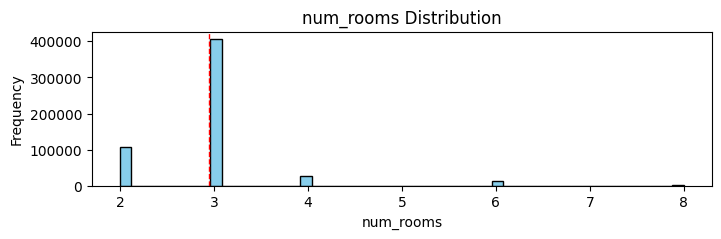

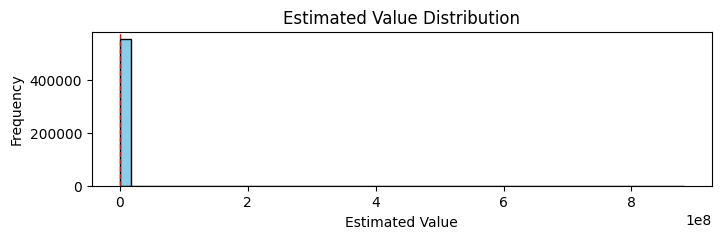

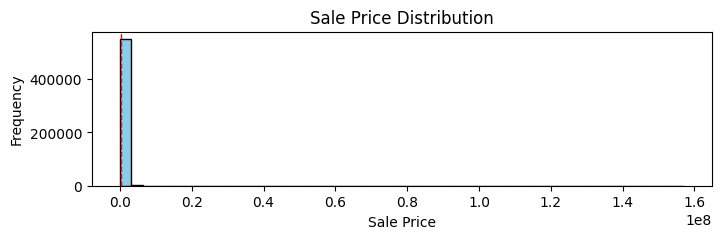

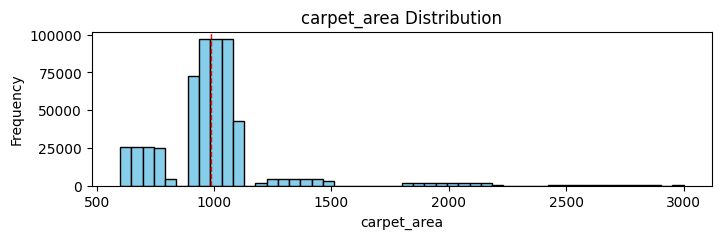

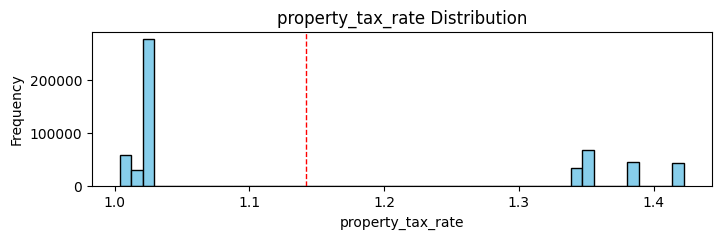

In [62]:
def plot_numerical_distributions(df, columns):
    """
    Plots the distributions of specified numerical columns in a DataFrame.
    
    """
    for column in columns:
        if column in df.columns:
            plt.figure(figsize=(8, 2))
            plt.hist(df[column].dropna(), bins=50, color='skyblue', edgecolor='black')
            plt.title(f'{column} Distribution')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=1)
            plt.show()
        else:
            print(f"Column '{column}' not found in DataFrame")

columns_to_plot = ['num_rooms', 'Estimated Value','Sale Price','carpet_area','property_tax_rate']
plot_numerical_distributions(train, columns_to_plot)

- The majority of properties have 3 rooms, followed by properties with 2 rooms. Properties with 4, 6, 7, or 8 rooms are rare.
- Most properties have an estimated value clustered near the lower end of the spectrum.
- Similar to estimated values, the sale prices are also clustered near the lower end.
- The majority of properties have a carpet area around 1000 sq ft.

Most of the numerical features are right skewed, so we can apply log-transformation to normalize this as most regression models are sensitive to skewed data.

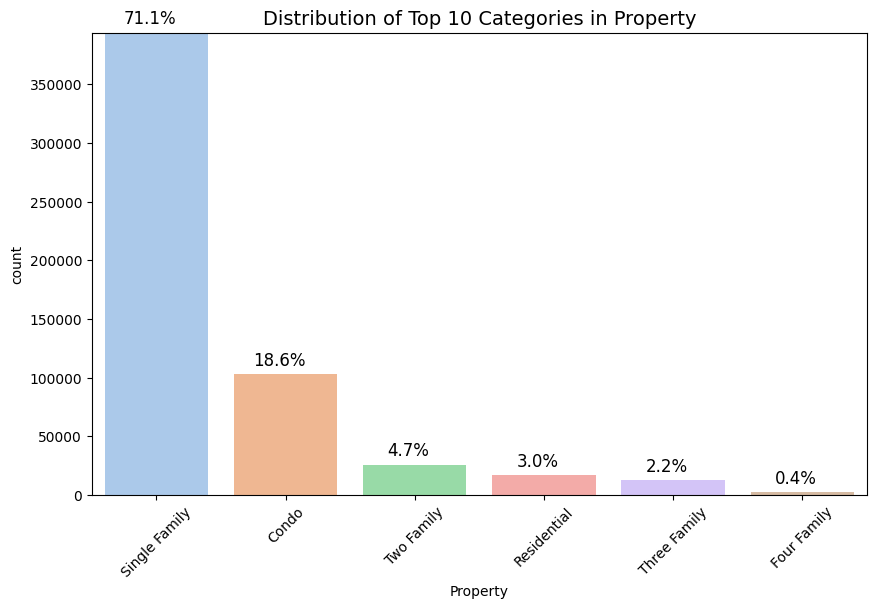

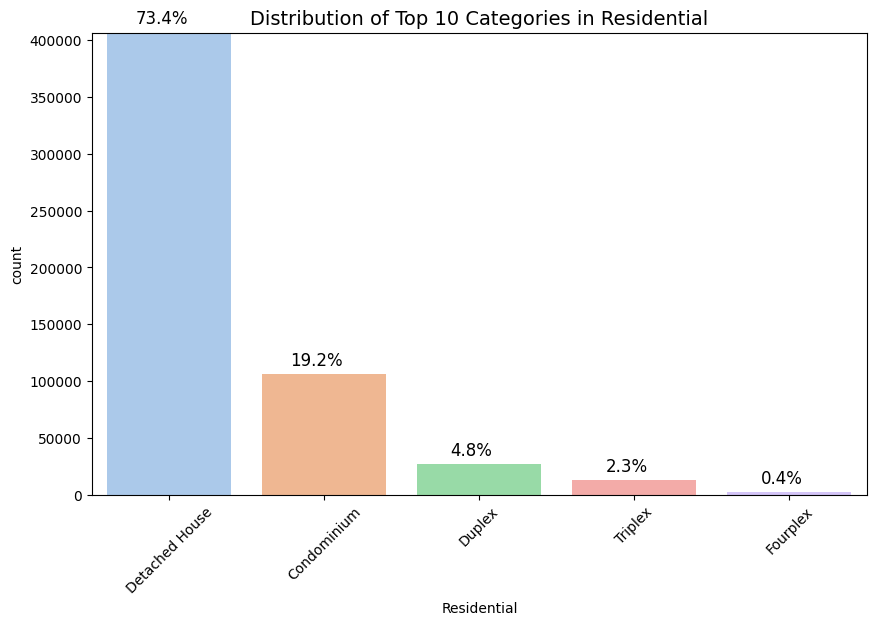

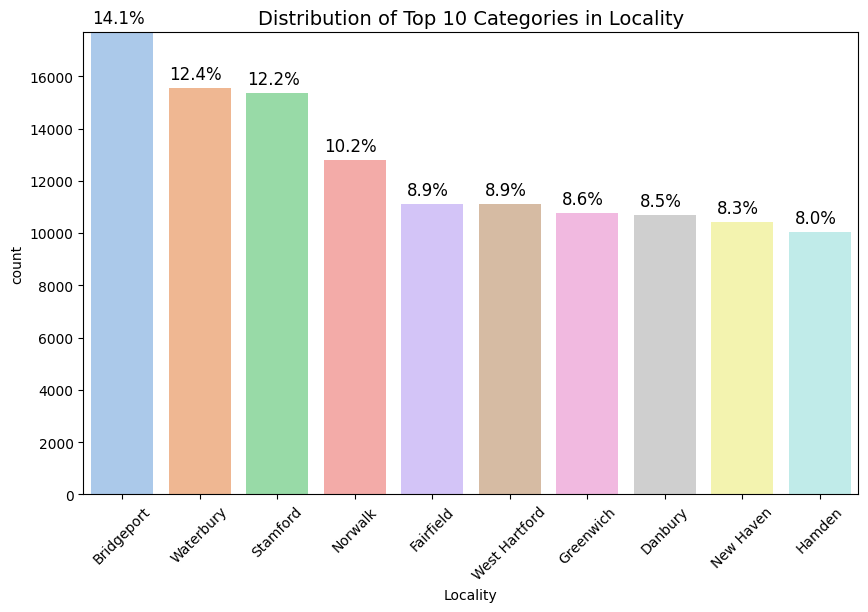

In [63]:
def plot_categorical_distributions(data, columns, top_n=10):
    """
    Plots the distributions of specified categorical columns, showing the top N categories.

    """
    for column in columns:
        # Get the top N categories
        top_categories = data[column].value_counts().nlargest(top_n).index
        top_data = data[data[column].isin(top_categories)]
        
        plt.figure(figsize=(10, 6))
        plt.title(f"Distribution of Top {top_n} Categories in {column}", fontsize=14)
        plot = sns.countplot(x=column, data=top_data, palette='pastel', order=top_categories)
        plt.ylim(0, top_data[column].value_counts().max() + 1)
        
        total = len(top_data[column])
        for p in plot.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = p.get_y() + p.get_height()
            plot.annotate(percentage, (x, y), size=12, ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
        plt.xticks(rotation=45)
        plt.show()

cat_vars = ['Property', 'Residential', 'Locality']
plot_categorical_distributions(train, cat_vars)

- A substantial portion of the dataset consists of Single Family homes and Detached Houses, indicating that the market is primarily oriented towards individual family residences.
- Condos and Condominiums also make up a significant part of the market, reflecting a demand for apartment-style living.
- The relatively lower percentage of Duplex, Triplex, and Fourplex properties indicates a lesser focus on multi-family units.
- The top localities/towns (Bridgeport, Waterbury, and Stamford) together account for nearly 40% of the dataset, highlighting key areas of interest for property investments.

In [64]:
def preprocess_data(train_df, test_df):

    # Log transformation for skewed features
    train_df['Estimated Value'] = np.log1p(train_df['Estimated Value'])
    train_df['Sale Price'] = np.log1p(train_df['Sale Price'])
    train_df['carpet_area'] = np.log1p(train_df['carpet_area'])

    test_df['Estimated Value'] = np.log1p(test_df['Estimated Value'])
    test_df['carpet_area'] = np.log1p(test_df['carpet_area'])
    
    return train_df, test_df

train_df, test_df = preprocess_data(train, test)

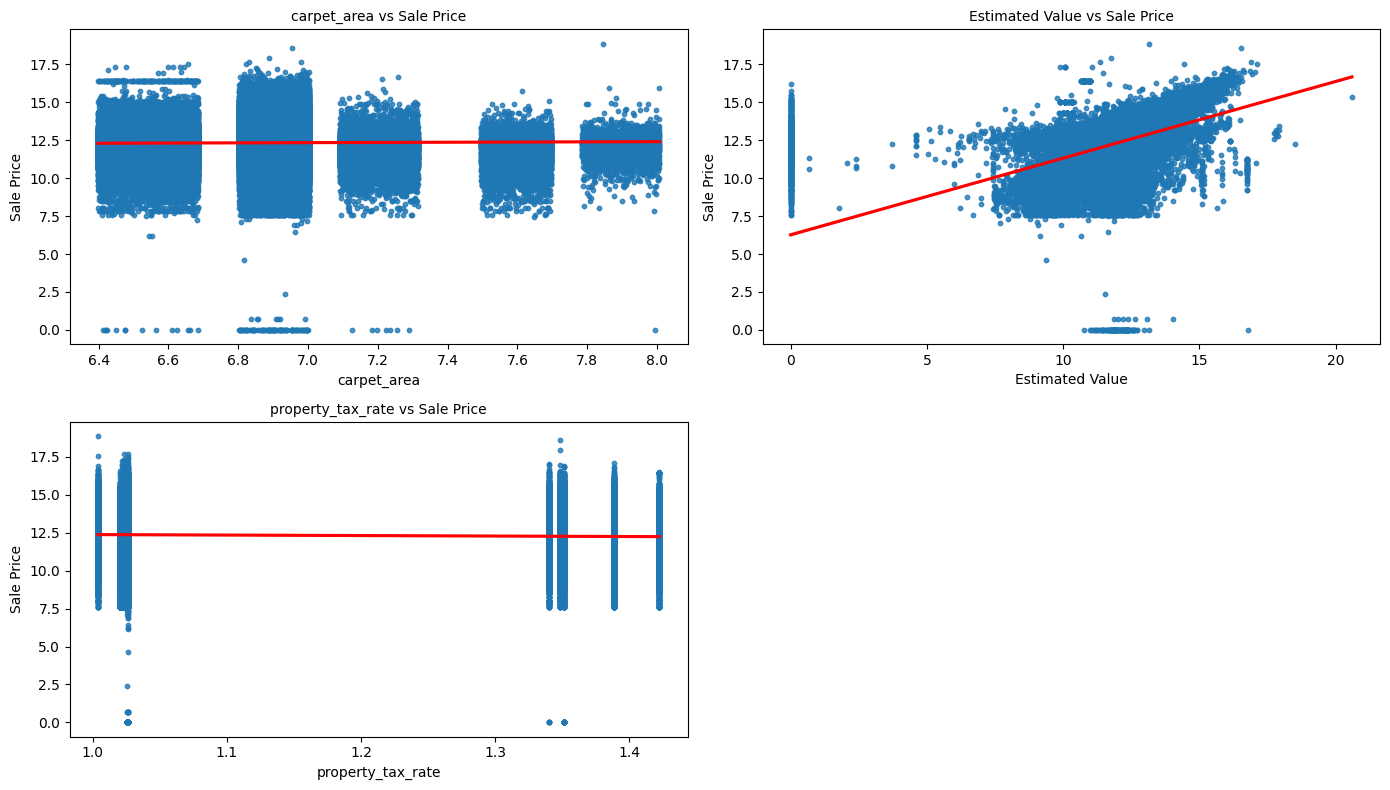

In [65]:
# Define the numerical columns
numerical_cols =  ['carpet_area','Estimated Value','property_tax_rate','Sale Price']

num_plots = len(numerical_cols[:-1])
n_cols = 2
n_rows = (num_plots + 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

# Plot each numerical column against 'Sale Price'
for i, col in enumerate(numerical_cols[:-1]):
    sns.regplot(data=train_df, x=col, y='Sale Price', ax=axes[i], scatter_kws={"s": 10}, line_kws={"color": "red"})
    axes[i].set_title(f'{col} vs Sale Price', fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Sale Price')

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- There is a clear positive correlation between Estimated Value and Sale Price. Higher estimated values generally correspond to higher sale prices. The regression line indicates a positive trend, suggesting that the estimated value is a good predictor of sale price.
- Most properties have a property tax rate around 1.0. Higher property tax rates (around 1.3 to 1.4) correspond to higher sale prices, but this relationship is not very strong. The regression line is almost flat, indicating that property tax rate does not significantly affect the sale price.
- The relationship between carpet_area and Sale Price is somewhat consistent, with distinct clusters visible for different carpet area ranges.The red line representing the regression line shows a slight positive trend, indicating that larger carpet areas tend to have higher sale prices, but the relationship is weak.

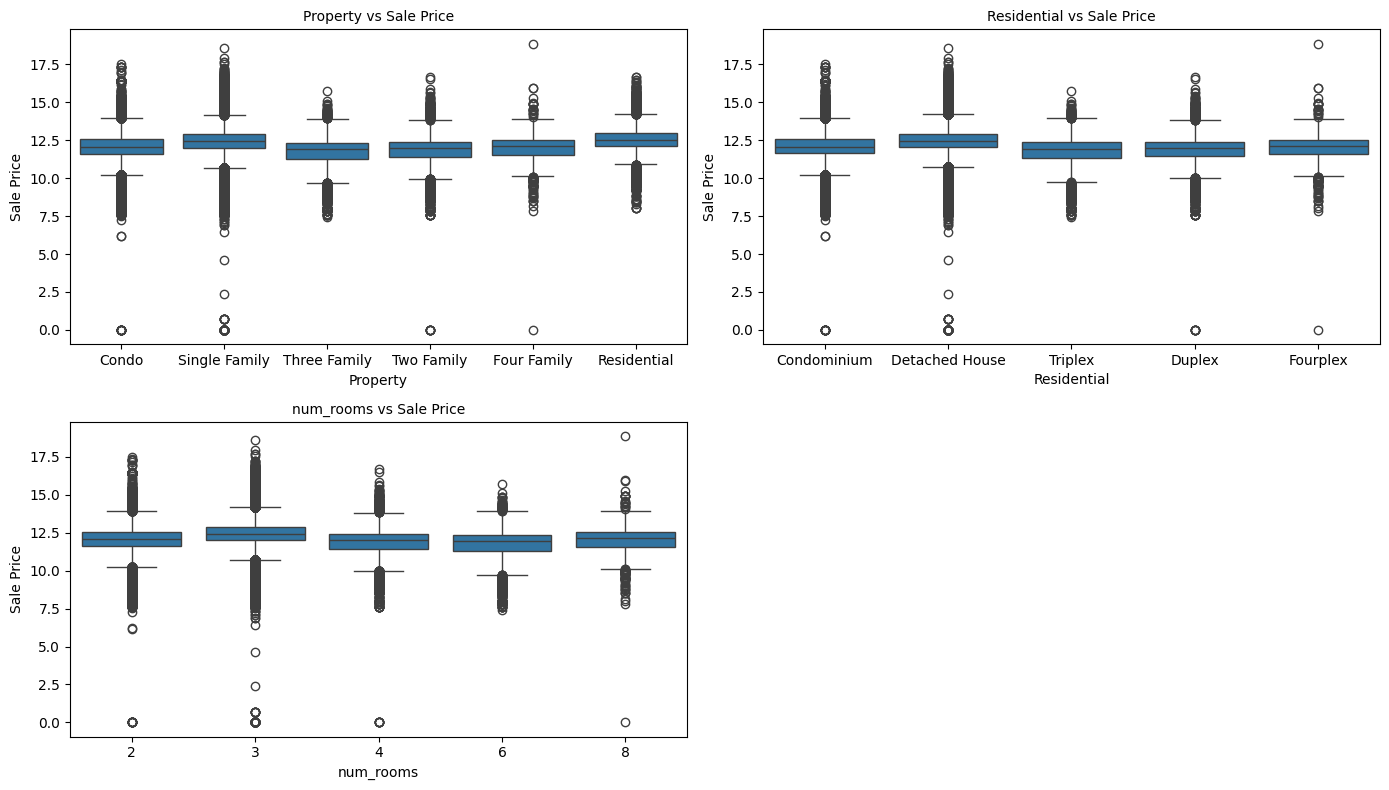

In [66]:
categorical_cols = ['Property', 'Residential','num_rooms']

num_plots = len(categorical_cols)
n_cols = 2
n_rows = (num_plots + 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

# Plot each categorical column against 'Sale Price'
for i, col in enumerate(categorical_cols):
    sns.boxplot(data=train_df, x=col, y='Sale Price', ax=axes[i])
    axes[i].set_title(f'{col} vs Sale Price', fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Sale Price')

# Remove any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Single Family and Condo properties tend to have higher median sale prices compared to other property types.
- Properties with 3 rooms have the highest median sale price, followed by properties with 2 rooms.
- Detached House and Condominium properties have higher median sale prices compared to other residential types.

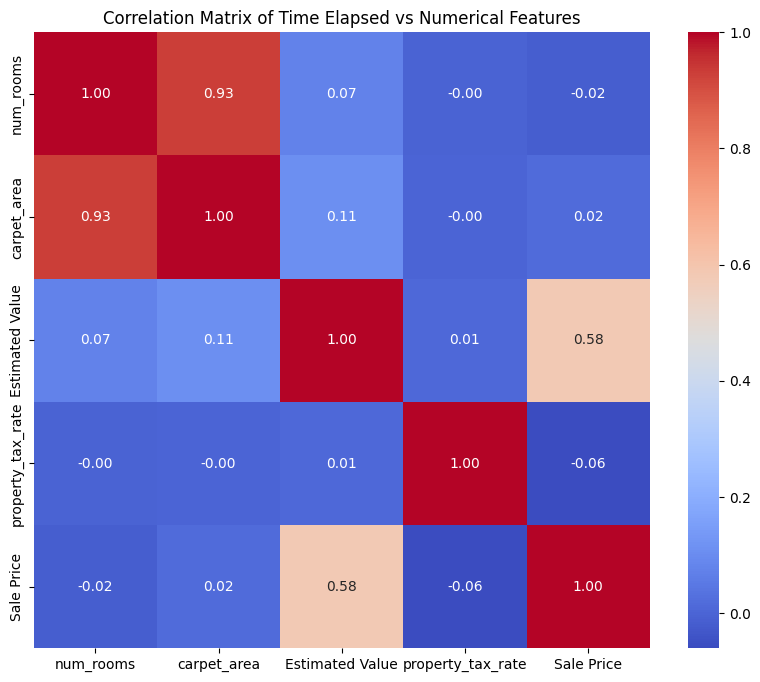

In [67]:
def correlation(df):
    """
    Plots correlation matrix.

    """
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title('Correlation Matrix of Time Elapsed vs Numerical Features')
    plt.show()

correlation(train_df[['num_rooms','carpet_area','Estimated Value','property_tax_rate','Sale Price']])

- There is a very high positive correlation (0.92) between num_rooms and carpet_area, suggesting that properties with more rooms tend to have larger carpet areas. This makes intuitive sense as larger properties usually have more rooms.
- Estimated Value has a moderate positive correlation (0.29) with Sale Price. This indicates that properties with higher estimated values tend to have higher sale prices.
- carpet_area and num_rooms have very low correlations with Sale Price (0.02 and -0.02, respectively). This suggests that these features do not individually have a strong impact on the sale price.

In [68]:
def calculate_predictive_power(df, target):
    """
    Calculates the predictive power score (PPS) for variables in a dataframe against a target variable.
    
    """
    predictors_df = pps.predictors(df, target)
    sorted_predictors = predictors_df.sort_values(by="ppscore", ascending=False)
    
    return sorted_predictors

predictors_df = calculate_predictive_power(train_df, "Sale Price")
predictors_df

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Estimated Value,Sale Price,0.289098,regression,True,mean absolute error,0.65,0.462086,DecisionTreeRegressor()
1,Locality,Sale Price,0.208236,regression,True,mean absolute error,0.65,0.514646,DecisionTreeRegressor()
2,Property,Sale Price,0.026505,regression,True,mean absolute error,0.65,0.632772,DecisionTreeRegressor()
3,Residential,Sale Price,0.025440,regression,True,mean absolute error,0.65,0.633464,DecisionTreeRegressor()
4,num_rooms,Sale Price,0.025440,regression,True,mean absolute error,0.65,0.633464,DecisionTreeRegressor()
5,property_tax_rate,Sale Price,0.004441,regression,True,mean absolute error,0.65,0.647113,DecisionTreeRegressor()
6,carpet_area,Sale Price,0.000000,regression,True,mean absolute error,0.65,0.702920,DecisionTreeRegressor()


- Indicates that Estimated Value is the strongest predictor of Sale Price among the features listed. The model score of 0.461697 suggests that using Estimated Value in a decision tree regression model improves the prediction accuracy compared to the baseline mean absolute error (0.65).
- Locality has second highest PPS score of 0.2086.
- Property, Residential, num_rooms, property_tax_rate, carpet_area: These features have lower PPS scores, indicating weaker predictive power compared to Estimated Value and Locality. Despite their low PPS scores, they still show some improvement over the baseline when used in a decision tree regression model, as indicated by their respective model scores.

In [69]:
def label_encode_columns(df, columns):
    """
    Performs label encoding on specified columns in a DataFrame.

    """
    label_encoders = {}
    for column in columns:
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
        label_encoders[column] = label_encoder
    return df, label_encoders

columns_to_encode = ['Locality','Residential', 'Property']
train_encoded, encoders = label_encode_columns(train_df, columns_to_encode)
test_encoded, encoders = label_encode_columns(test_df, columns_to_encode)
train_encoded.head()

,Locality,Estimated Value,Sale Price,Property,Residential,num_rooms,carpet_area,property_tax_rate
0,57,13.474809,13.790194,0,0,2,6.634633,1.025953
1,41,11.695005,12.154258,3,1,3,6.826545,1.025953
2,118,13.111365,13.623140,3,1,3,6.890609,1.025953
3,105,12.194005,13.017005,3,1,3,6.884487,1.025953
4,88,11.565907,12.206078,3,1,3,6.854355,1.025953


In [70]:
def set_features_and_target(df):
    '''
    Returns two data frames with features and target variables.
            Parameters:
                    df (str): Pandas dataframe
    '''
    X = df.drop(['Sale Price'], axis=1)
    y = df['Sale Price']
    
    return X,y
                 
X,y = set_features_and_target(train_encoded)
print(X.shape, y.shape)

(553952, 7) (553952,)


In [71]:
def train_test_split_df(X,y):
    '''
    Creates train and test split.

    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_df(X,y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(332371, 7) (332371,)
(221581, 7) (221581,)


In [72]:
def model_application(X_train, y_train, optimiser):
    '''
    Model application. If optimiser is true, a grid search is applied to optimise the model. 
    If optimiser is false, the base model is used.

    '''
    if optimiser:
        # Define the parameters for grid search
        params = {
            'max_features': [1, 3, 10, 0.5],
            'min_samples_split': [2, 3, 10],
            'min_samples_leaf': [1, 3, 10],
            'criterion': ["squared_error", "absolute_error"]
        }

        # Using K-fold cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=15)

        # Building the model
        rf = RandomForestRegressor()

        # Parameter estimation using GridSearch
        grid = GridSearchCV(rf, param_grid=params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, verbose=1)
        
        # Fitting the model
        grid.fit(X_train, y_train)

        best_score = grid.best_score_
        print('Best Score:', best_score)
        print('Best Params:', grid.best_params_)
        print('Best Estimator:', grid.best_estimator_)

        rf_reg = grid.best_estimator_
    else:
        rf_reg = RandomForestRegressor(n_estimators=150,
                                       max_depth=16,
                                       criterion='squared_error',
                                       min_samples_split=10,
                                       max_leaf_nodes=20,
                                       max_features=0.5,
                                       bootstrap=True)
        rf_reg.fit(X_train, y_train)

    return rf_reg

optimiser = False
rf_reg = model_application(X_train, y_train, optimiser)

In [73]:
def model_predict(rf, X_test):
    """
    Create y_pred, model prediction based on test set features.

    """
    y_pred = rf.predict(X_test)
    return y_pred

y_pred = model_predict(rf_reg, X_test)

# Print R-squared for training and test sets
print('Training R-squared Score (%):', rf_reg.score(X_train, y_train) * 100)
print('Test R-squared Score (%):', rf_reg.score(X_test, y_test) * 100)

# Print other regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Training R-squared Score (%): 60.78172960099093
Test R-squared Score (%): 60.43312611584122
Mean Squared Error: 0.3226635295564176
Root Mean Squared Error: 0.5680347960789177


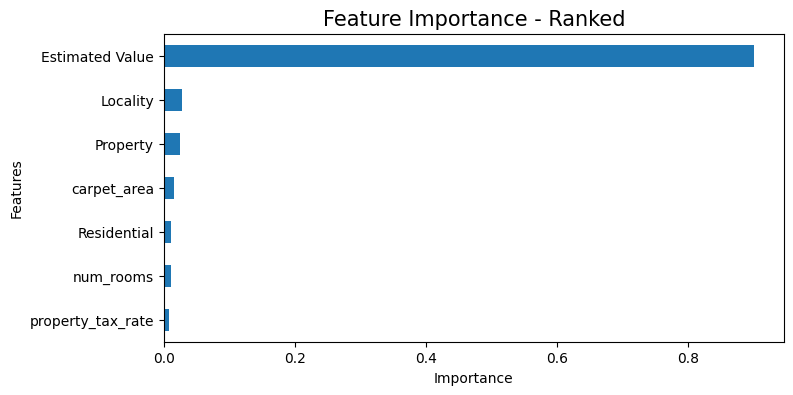

In [74]:
def plot_feature_importance(model, feature_names, n=30):
    
    '''
    Produces a plot displaying features that are most important predictors of the target feature.
            Parameters:
                    random forest model
                    feature names
    '''
    
    plt.figure(figsize=(8, 4))

    feat_importances = pd.Series(model.feature_importances_, index=feature_names)
    feat_importances.nsmallest(n).plot(kind='barh')
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title("Feature Importance - Ranked", fontsize=15)
    plt.show()

plot_feature_importance(rf_reg, X_train.columns)

In [75]:
# Predict sale prices for test data
test_predictions = rf_reg.predict(test_encoded)

# Revert the log transformation
#test_predictions = np.expm1(test_predictions_log)

# Segment properties based on gain
test_encoded['Predicted Sale Price'] = test_predictions
#test_encoded['Estimated Value'] = np.expm1(test_encoded['Estimated Value'])  # Revert log transformation for Estimated Value
#test_encoded['carpet_area'] = np.expm1(test_encoded['carpet_area']) 
test_encoded['Gain'] = (test_encoded['Predicted Sale Price'] - test_encoded['Estimated Value']) / 100

# Display the first few rows of the dataframe
test_encoded.head()

,Locality,Estimated Value,Property,Residential,num_rooms,carpet_area,property_tax_rate,Predicted Sale Price,Gain
0,86,11.927687,0,1,3,6.854355,1.46,12.177922,0.002502
1,96,13.439945,0,1,3,6.958448,1.46,13.321200,-0.001187
2,28,11.931840,0,1,3,6.830874,1.46,12.196517,0.002647
3,78,11.958451,0,2,4,7.099202,1.46,12.055058,0.000966
4,5,11.598837,0,1,3,6.993933,1.46,11.850511,0.002517


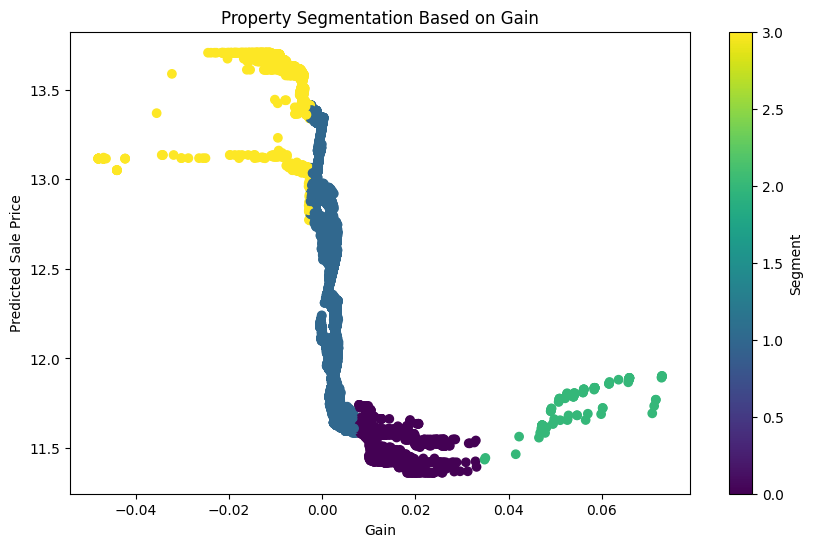

,Locality,Estimated Value,Property,Residential,num_rooms,carpet_area,property_tax_rate,Predicted Sale Price,Gain,Segment
0,86,11.927687,0,1,3,6.854355,1.46,12.177922,0.002502,1
1,96,13.439945,0,1,3,6.958448,1.46,13.321200,-0.001187,1
2,28,11.931840,0,1,3,6.830874,1.46,12.196517,0.002647,1
3,78,11.958451,0,2,4,7.099202,1.46,12.055058,0.000966,1
4,5,11.598837,0,1,3,6.993933,1.46,11.850511,0.002517,1


In [76]:
def segment(model, test_encoded):
    
    # Use KMeans to create 4 segments
    kmeans = KMeans(n_clusters=4, random_state=42)
    test_encoded['Segment'] = kmeans.fit_predict(test_encoded[['Gain']])
    
    # Visualize the segments
    plt.figure(figsize=(10, 6))
    plt.scatter(test_encoded['Gain'], test_encoded['Predicted Sale Price'], c=test_encoded['Segment'], cmap='viridis')
    plt.title('Property Segmentation Based on Gain')
    plt.xlabel('Gain')
    plt.ylabel('Predicted Sale Price')
    plt.colorbar(label='Segment')
    plt.show()
    
    return test_encoded, kmeans

test_encoded, kmeans = segment(rf_reg, test_encoded)
test_encoded.head()

In [77]:
def aggregate_user_segments(df):
    """
    Aggregates user features by segment.

    """
    segments = df.groupby('Segment').agg({
        'Predicted Sale Price': ('mean'), 
        'carpet_area': ('mean'), 
        'Estimated Value': ('mean'), 
        'num_rooms': ('mean'),
        'Gain':('sum')
    })

    return segments

aggregate_user_segments(test_encoded)

,Predicted Sale Price,carpet_area,Estimated Value,num_rooms,Gain
Segment,,,,,
0,11.573889,6.722484,10.319010,2.526457,27.983806
1,12.260407,6.879334,12.028838,2.970613,91.800610
2,11.761741,6.639076,6.141052,2.240385,5.845516
3,13.486419,6.884231,14.221291,2.944866,-14.528429


In [78]:
test_encoded[['Segment']].to_csv('/Users/mncedisimncwabe/Downloads/segment_predicted.csv', index=False)
print("Submission file created successfully")

Submission file created successfully
